### Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.regularizers import l1, l2


import requests

### Functions section

In [3]:
#This function will send me a message ont elegram when the neural network is done fitting


def telegram_bot_sendtext(bot_message):
    bot_token = '1653403779:AAFxxs8vLirSm-nXejEvmHpBoASuZOO75D8'
    bot_chatID = '1589422433'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + \
                '&parse_mode=MarkdownV2&text=' + bot_message
    response = requests.get(send_text)
    
    return response.json

### Data Set-up

In [9]:
##setting the directory from which I want to get my data

data_dir = 'augmented_data/layer/layer_2'

In [10]:
#Setting the batch size

batch_size = 256

#The height and width of each of my images in 256 picels so I will hard code that

img_height = 256
img_width = 256

### Train, test, splitting

In [11]:
#Setting training set to 80% of my data
#I'm using the batch_size, img_height, img_width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 29984 files belonging to 10 classes.
Using 23988 files for training.


In [12]:
#Setting testing set to be 20% of my data

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 29984 files belonging to 10 classes.
Using 5996 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['bacterial_spot', 'early_blight', 'healthy', 'late_blight', 'leaf_mold', 'leaf_septoria', 'mosaic_virus', 'spider_mites', 'target_spot', 'yellow_leaf_curl_virus']


In [14]:
num_classes = 10

### Layer Set-up For Model

In [15]:
#This is the layer that will augment the data so I have mroe images to work from
#The code flips horizontally, does a random rotation, and random zoom

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [22]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer = l1(0.0001)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(10)
])


In [23]:
#Currently this is set to the default learning rate, but I have it here
#so I have the option to change it if I see fit

opt = keras.optimizers.Adam(learning_rate=0.005)

In [24]:
#Compiling model with the adam optimizer and learning rate I set int eh previous cell
#Using accuracy as the metric

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
#Quick model summary to see what it will look like visually

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)       

### Model Fitting

In [26]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

telegram_bot_sendtext('done')

Epoch 1/30
94/94 [==============================] - 169s 2s/step - loss: 6.0304 - accuracy: 0.1041 - val_loss: 2.3315 - val_accuracy: 0.1189
Epoch 2/30
94/94 [==============================] - 167s 2s/step - loss: 2.2215 - accuracy: 0.1760 - val_loss: 2.3623 - val_accuracy: 0.0931
Epoch 3/30
94/94 [==============================] - 170s 2s/step - loss: 2.3192 - accuracy: 0.0979 - val_loss: 2.3076 - val_accuracy: 0.0932
Epoch 4/30
94/94 [==============================] - 168s 2s/step - loss: 2.3070 - accuracy: 0.0974 - val_loss: 2.3071 - val_accuracy: 0.0932
Epoch 5/30
94/94 [==============================] - 167s 2s/step - loss: 2.3070 - accuracy: 0.0958 - val_loss: 2.3071 - val_accuracy: 0.0932
Epoch 6/30
94/94 [==============================] - 168s 2s/step - loss: 2.3069 - accuracy: 0.0984 - val_loss: 2.3071 - val_accuracy: 0.0932
Epoch 7/30
94/94 [==============================] - 168s 2s/step - loss: 2.3069 - accuracy: 0.0996 - val_loss: 2.3072 - val_accuracy: 0.0932
Epoch 8/30
94

<bound method Response.json of <Response [200]>>

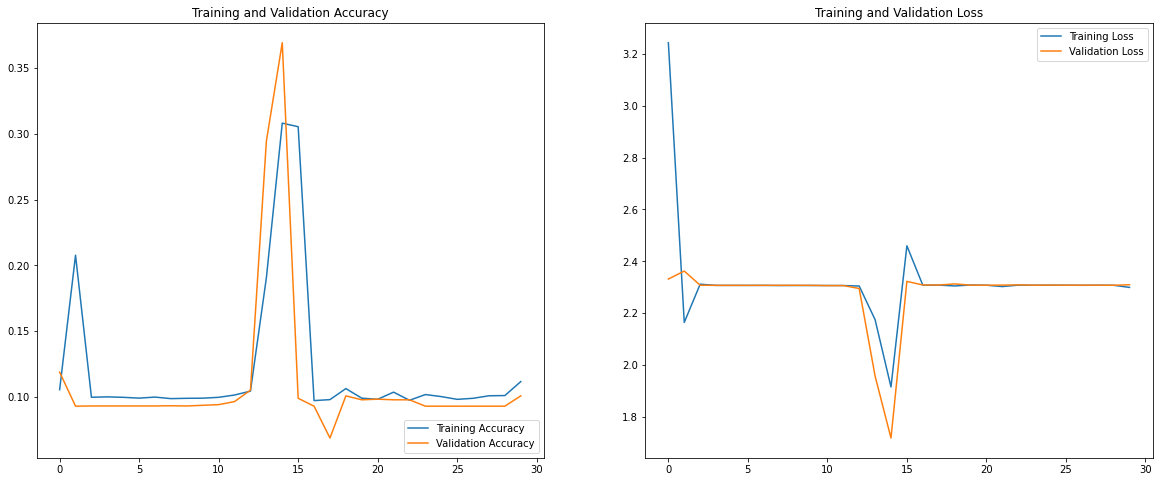

In [27]:
#This cell assigns the accuracy, val accuracy, loss, and val loss to variables
#for plotting
#Matplotlib is used to plot the loss and accuracy curves on the y axis and epochs on the x axis

#SAVE THESE RESULTS, DROPOUT = 0.4



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()








#SAVE THESE RESULTS, DROPOUT = 0.4